In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from itertools import chain
from matplotlib import pyplot as plt
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
#import keras_tuner as kt
df = pd.read_csv("drive/MyDrive/Engineer's Project/output_eur_pln.csv")

In [ ]:
#df.pop('usa_cpi')
#df.pop('pol_cpi')
#df.pop('usa_inter')
#df.pop('pol_inter')
df.pop('Date')

0       2010.11.15
1       2010.11.16
2       2010.11.17
3       2010.11.18
4       2010.11.19
           ...    
3537    2022.03.27
3538    2022.03.28
3539    2022.03.29
3540    2022.03.30
3541    2022.03.31
Name: Date, Length: 3542, dtype: object

In [ ]:
scaler = MinMaxScaler()
df_numpy = df.to_numpy() 
#len(df_numpy[:2500])
scaler1 = scaler.fit(df_numpy[:3000])
df_scalled = scaler1.transform(df_numpy)
#df_scaled_all = scaler.
df_scalled = pd.DataFrame(df_scalled, columns=[
  'Opening', 'High', 'Low', 'Closing','Momentum', 'Range', 'ohlc'])

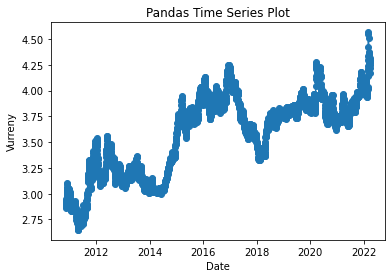

In [ ]:
plt.plot(date,df["Closing"], marker='o')

# Labelling 

plt.xlabel("Date")
plt.ylabel("Vurreny")
plt.title("Pandas Time Series Plot")

# Display

plt.show()

In [ ]:
date = pd.to_datetime(df["Date"])

In [ ]:
df_scalled.head(5)

,Opening,High,Low,Closing,Momentum,Range,ohlc
0,0.136591,0.112886,0.153342,0.136824,0.430161,0.035787,0.135242
1,0.119463,0.128421,0.126540,0.119453,0.545131,0.227246,0.123938
2,0.133874,0.139684,0.128807,0.133960,0.499848,0.268997,0.134608
3,0.150008,0.140201,0.159742,0.150048,0.521365,0.133007,0.150470
4,0.125477,0.120912,0.134007,0.125477,0.540389,0.159251,0.126881


In [ ]:
lookback = 15 #15 for 1day
step = 1
delay = 0 #0 for 1day
batch_size = 128

In [ ]:
float_data = np.array(df_scalled).astype('float32')

In [ ]:
len(float_data[3001:])

541

In [ ]:
def generator(data, lookback, delay, min_index, max_index,shuffle=False, batch_size=128, step=1):
  if max_index is None:
    max_index = len(data) - delay - 1
  i = min_index + lookback
  while 1:
    if shuffle:
      rows = np.random.randint(
        min_index + lookback, max_index, size=batch_size)
    else:
      if i + batch_size >= max_index:
        i = min_index + lookback
      rows = np.arange(i, min(i + batch_size, max_index))
      i += len(rows)
    samples = np.zeros((len(rows),lookback // step,data.shape[-1]))
    targets = np.zeros((len(rows),))
    for j, row in enumerate(rows):
      indices = range(rows[j] - lookback, rows[j], step)
      samples[j] = data[indices]
      targets[j] = data[rows[j] + delay][3] 
    yield samples, targets

In [ ]:
train_gen = generator(float_data,
lookback=lookback,
delay=delay,
min_index=0,
max_index=2500-delay,
#shuffle=True,
step=step,
batch_size=batch_size)

In [ ]:
val_gen = generator(float_data,
lookback=lookback,
delay=delay,
min_index=2501,
max_index=3000-delay,
step=step,
batch_size=batch_size)

In [ ]:
test_gen = generator(float_data,
lookback=lookback,
delay=delay,
min_index=3001,
max_index=3541-delay,
step=step,
batch_size=batch_size)

In [ ]:
len(float_data)

3542

In [ ]:
test_steps

525

In [ ]:
train_steps = (2500 - lookback)
val_steps = (3000 - 2501 - lookback)
test_steps = (3541 - 3001 - lookback)

In [ ]:
model = tf.keras.models.Sequential()
model.add(layers.GRU(140,
  activation='sigmoid',
  #dropout=0.1,
  #recurrent_dropout=0.1,
  return_sequences=True,
  input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(120,
  activation='sigmoid',))
model.add(layers.GRU(4,
  activation='sigmoid',
  #dropout=0.1,
  #recurrent_dropout=0.1,
  input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1,
  activation='sigmoid'))
model.compile(optimizer= tf.keras.optimizers.RMSprop(0.01), loss='mae')
history = model.fit(train_gen,
  steps_per_epoch=100,
  epochs=200,
  validation_data=val_gen,
  validation_steps=val_steps)

Epoch 1/200
100/100 [==============================] - 21s 180ms/step - loss: 0.1308 - val_loss: 0.1073
Epoch 2/200
100/100 [==============================] - 17s 173ms/step - loss: 0.1109 - val_loss: 0.0795
Epoch 3/200
100/100 [==============================] - 18s 180ms/step - loss: 0.0676 - val_loss: 0.0110
Epoch 4/200
100/100 [==============================] - 17s 167ms/step - loss: 0.0538 - val_loss: 0.0817
Epoch 5/200
100/100 [==============================] - 17s 168ms/step - loss: 0.0428 - val_loss: 0.0192
Epoch 6/200
100/100 [==============================] - 18s 178ms/step - loss: 0.0357 - val_loss: 0.0486
Epoch 7/200
100/100 [==============================] - 19s 188ms/step - loss: 0.0328 - val_loss: 0.0273
Epoch 8/200
100/100 [==============================] - 17s 168ms/step - loss: 0.0310 - val_loss: 0.0251
Epoch 9/200
100/100 [==============================] - 17s 168ms/step - loss: 0.0294 - val_loss: 0.0307
Epoch 10/200
100/100 [==============================] - 17s 168m

In [ ]:
eval = model.evaluate(test_gen, steps = test_steps)

525/525 [==============================] - 14s 27ms/step - loss: 0.0771


In [ ]:
model.save("drive/MyDrive/Engineer's Project/standard_gru_eur_pln_200epochs.h5")

In [ ]:
del model

20 epochs - 0.03 <br>
100 - 0.0195 <br>
200  - 0.0147 <br>
300 -  0.0184 <br>
400 - 0.0149<br>
600 - 0.0213<br>
all with dropout 0<br>

with correct delay = 0
200 epok - 0.0111!

In [ ]:
model = tf.keras.models.Sequential()
model.add(layers.LSTM(120,
  activation='sigmoid',
  dropout=0.1,
  #recurrent_dropout=0.1,
  input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(160,
  activation='sigmoid',))
model.add(layers.Dense(1,
  activation='sigmoid'))
model.compile(optimizer= tf.keras.optimizers.RMSprop(0.01), loss='mae')
history = model.fit(train_gen,
  steps_per_epoch=200,
  epochs=200,
  validation_data=val_gen,
  validation_steps=val_steps)

Epoch 1/200
200/200 [==============================] - 18s 81ms/step - loss: 0.1990 - val_loss: 0.0854
Epoch 2/200
200/200 [==============================] - 16s 80ms/step - loss: 0.0827 - val_loss: 0.0254
Epoch 3/200
200/200 [==============================] - 16s 79ms/step - loss: 0.0630 - val_loss: 0.0461
Epoch 4/200
200/200 [==============================] - 16s 79ms/step - loss: 0.0537 - val_loss: 0.0221
Epoch 5/200
200/200 [==============================] - 16s 79ms/step - loss: 0.0473 - val_loss: 0.0191
Epoch 6/200
200/200 [==============================] - 16s 79ms/step - loss: 0.0453 - val_loss: 0.0718
Epoch 7/200
200/200 [==============================] - 16s 80ms/step - loss: 0.0420 - val_loss: 0.0517
Epoch 8/200
200/200 [==============================] - 16s 80ms/step - loss: 0.0404 - val_loss: 0.0497
Epoch 9/200
200/200 [==============================] - 16s 80ms/step - loss: 0.0391 - val_loss: 0.0184
Epoch 10/200
200/200 [==============================] - 16s 81ms/step - l

KeyboardInterrupt: ignored

In [ ]:
eval = model.evaluate(test_gen, steps = test_steps)

527/527 [==============================] - 12s 22ms/step - loss: 0.0130


IndexError: ignored

In [ ]:

model.save("drive/MyDrive/Engineer's Project/best_with_GRU2.h5")

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss, without CPI & Interest, CLOSING PRICE PREDICTION')
plt.legend()
plt.show()

Do a tuner of architecture above, 110-130, 150-170 and dropout, with step of 5

Model same, but with dropout and recurrent dropout 0.1





In [ ]:
model1 = tf.keras.models.Sequential()
model1.add(layers.LSTM(120,
  activation='sigmoid',
  dropout=0.1,
  recurrent_dropout=0.1,
  input_shape=(None, float_data.shape[-1])))
model1.add(layers.Dense(160,
  activation='sigmoid',))
model1.add(layers.Dense(1,
  activation='sigmoid'))
model1.compile(optimizer= tf.keras.optimizers.RMSprop(0.01), loss='mae')
history1 = model1.fit(train_gen,
  steps_per_epoch=200,
  epochs=200,
  validation_data=val_gen,
  validation_steps=val_steps)

Epoch 1/200
200/200 [==============================] - 22s 93ms/step - loss: 0.2084 - val_loss: 0.2017
Epoch 2/200
200/200 [==============================] - 18s 92ms/step - loss: 0.0775 - val_loss: 0.0804
Epoch 3/200
200/200 [==============================] - 18s 90ms/step - loss: 0.0611 - val_loss: 0.0450
Epoch 4/200
200/200 [==============================] - 18s 92ms/step - loss: 0.0529 - val_loss: 0.0238
Epoch 5/200
200/200 [==============================] - 19s 93ms/step - loss: 0.0478 - val_loss: 0.0629
Epoch 6/200
200/200 [==============================] - 18s 92ms/step - loss: 0.0462 - val_loss: 0.0333
Epoch 7/200
200/200 [==============================] - 18s 91ms/step - loss: 0.0428 - val_loss: 0.0220
Epoch 8/200
200/200 [==============================] - 19s 98ms/step - loss: 0.0420 - val_loss: 0.0426
Epoch 9/200
200/200 [==============================] - 20s 98ms/step - loss: 0.0400 - val_loss: 0.0541
Epoch 10/200
200/200 [==============================] - 19s 94ms/step - l

In [ ]:
eval1 = model1.evaluate(test_gen, steps = test_steps)

527/527 [==============================] - 12s 23ms/step - loss: 0.0681


In [ ]:
del model2

without steps per epoch- infinity
120-160 without dropout 0.017
120-5 dropout 0.15

In [ ]:
model2 = tf.keras.models.Sequential()
model2.add(layers.LSTM(120,
  activation='sigmoid',
  dropout=0.15,
  recurrent_dropout=0.1,
  input_shape=(None, float_data.shape[-1])))
model2.add(layers.Dense(5,
  activation='sigmoid',))
model2.add(layers.Dense(1,
  activation='sigmoid'))
model2.compile(optimizer= tf.keras.optimizers.RMSprop(0.01), loss='mae')
history2 = model2.fit(train_gen,
  steps_per_epoch=50,
  epochs=200,
  validation_data=val_gen,
  validation_steps=val_steps)

Epoch 1/200
50/50 [==============================] - 9s 144ms/step - loss: 0.1801 - val_loss: 0.0402
Epoch 2/200
50/50 [==============================] - 7s 139ms/step - loss: 0.1337 - val_loss: 0.2722
Epoch 3/200
50/50 [==============================] - 7s 138ms/step - loss: 0.0901 - val_loss: 0.0824
Epoch 4/200
50/50 [==============================] - 7s 140ms/step - loss: 0.0673 - val_loss: 0.0667
Epoch 5/200
50/50 [==============================] - 7s 136ms/step - loss: 0.0683 - val_loss: 0.0436
Epoch 6/200
50/50 [==============================] - 7s 139ms/step - loss: 0.0603 - val_loss: 0.0552
Epoch 7/200
50/50 [==============================] - 7s 140ms/step - loss: 0.0584 - val_loss: 0.0269
Epoch 8/200
50/50 [==============================] - 7s 139ms/step - loss: 0.0613 - val_loss: 0.1071
Epoch 9/200
50/50 [==============================] - 7s 138ms/step - loss: 0.0548 - val_loss: 0.0437
Epoch 10/200
50/50 [==============================] - 8s 155ms/step - loss: 0.0552 - val_lo

Try smooting and plots

In [ ]:
scaler = MinMaxScaler()
smoothing_window_size = 100
for di in range (0,3000,smoothing_window_size):
  scaler.fit(float_data[di:di+smoothing_window_size,:])
  float_data[di:di+smoothing_window_size,:] = scaler.transform(float_data[di:di+smoothing_window_size,:])
scaler.fit(float_data[di+smoothing_window_size:,:])
float_data[di+smoothing_window_size:,:] = scaler.tranform(float_data[di+smoothing_window_size:,:])
#test data = scaler transform(float_data[3001:] transform test data

In [ ]:
eval2 = model2.evaluate(test_gen, steps = test_steps)

527/527 [==============================] - 6s 11ms/step - loss: 0.0174
